In [1]:
import numpy as np
import pandas as pd

In [2]:
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set(style='whitegrid', palette='deep', font='sans-serif')
except:
    import matplotlib.pyplot as plt

In [3]:
filename = 'https://github.com/lmassaron/datasets/'
filename += 'releases/download/1.0/wine_quality.feather'
wine = pd.read_feather(filename)

In [4]:
np.random.seed(42)
train = (wine.groupby('quality')
             .apply(lambda x: x.sample(frac=.7))
             .reset_index(drop=True))

test = wine[~wine.index.isin(train.index)]

X_train = train.iloc[:,1:]
y_train = train.iloc[:,0]

X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]

In [5]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

series = [10, 25, 50, 100, 150, 200, 250, 300, 500]

test_scores = list()
for param in series:
    rf = RandomForestRegressor(n_estimators=param,
                               max_depth=14,
                               random_state=42,
                               n_jobs=-1)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    test_scores.append(mean_absolute_error(y_test, preds))

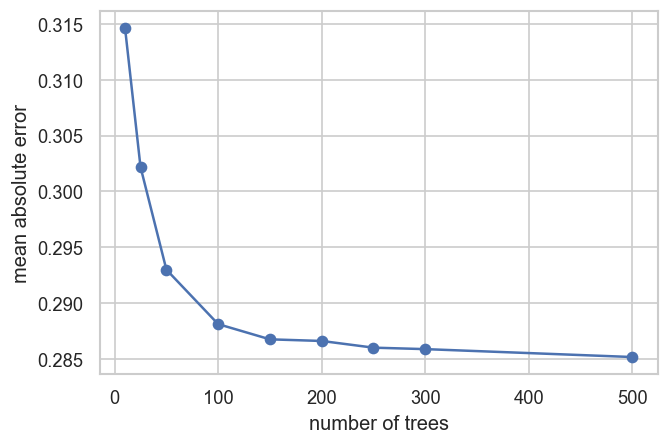

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=120)
plt.plot(series, test_scores, '-o')
plt.xlabel('number of trees')
plt.ylabel('mean absolute error')
plt.show()

## Understanding the importance measures

In [7]:
from sklearn.inspection import permutation_importance

In [8]:
rf = RandomForestRegressor(n_estimators=500,
                           max_features='sqrt',
                           random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=500, random_state=42)

In [9]:
preds = rf.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print(f"test mean absolute error for rf: {mae:0.3}")

test mean absolute error for rf: 0.228


In [10]:
result = permutation_importance(rf, X_test, 
   y_test, n_repeats=10, random_state=42, n_jobs=-1)

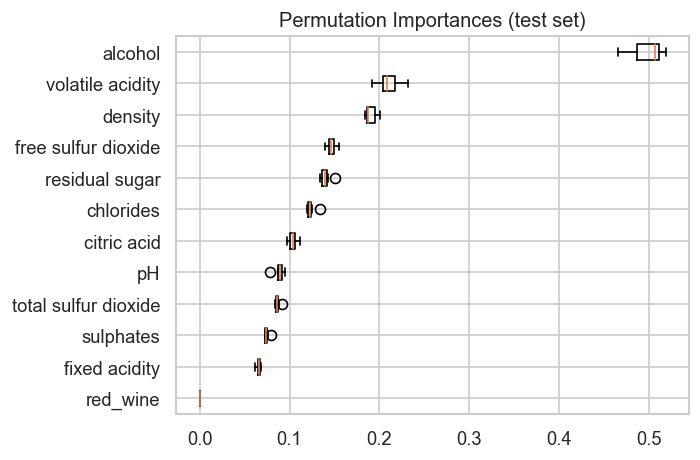

In [11]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(dpi=120)
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## Adaboost with different base learners

In [12]:
import numpy as np
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor

dt = DecisionTreeRegressor(max_depth=14)
lr = Ridge(alpha=1.0, normalize=True)
knn = KNeighborsRegressor(n_neighbors=1)

model_labels = ['Decision trees', 'Linear regression', 'KNN']
models = [dt, lr, knn]

for label, model in zip(model_labels, models):
    ada_model = AdaBoostRegressor(model, n_estimators=300, random_state=42)
    ada_model.fit(X_train, y_train)
    preds = ada_model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    print(f"test mae for {label}: {mae:0.3}")

test mae for Decision trees: 0.154
test mae for Linear regression: 0.563
test mae for KNN: 0.165


##  Testing Gradient boosting performance

In [13]:
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(n_estimators=500,
                                subsample=0.9, 
                                max_depth=12,
                                learning_rate=0.1,
                                random_state=42)
gbm.fit(X_train, y_train)

preds = gbm.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print(f"test mean absolute error for gbm: {mae:0.3}")

test mean absolute error for gbm: 0.121


## Blending solutions together

In [14]:
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR

gbm = GradientBoostingRegressor(n_estimators=500,
                                subsample=0.9, 
                                max_depth=12,
                                learning_rate=0.1,
                                random_state=42)

svr = SVR(C=10.0, gamma=0.3, epsilon=0.0001)

blender = VotingRegressor(estimators=[('gbm', gbm), ('svm', svr)],
                          n_jobs=-2)

blender.fit(X_train, y_train)

preds = blender.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print(f"test mean absolute error for blender: {mae:0.3}")

test mean absolute error for blender: 0.116


## Stacking solutions together

In [15]:
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import StratifiedKFold

gbm = GradientBoostingRegressor(n_estimators=300,
                                subsample=0.9, 
                                max_depth=16,
                                learning_rate=0.1,
                                random_state=42)

svr = SVR(C=10.0, gamma=0.4, epsilon=0.0001)

sfk = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

stacker = StackingRegressor(estimators=[('svm', svr)],
                            final_estimator=gbm,
                            passthrough=True,
                            cv=sfk, 
                            n_jobs=-2)
                                   
stacker.fit(X_train, y_train)
preds = stacker.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print(f"test mean absolute error for stacker: {mae:0.3}")

test mean absolute error for stacker: 0.162
